## Purpose

This notebook is to test whether the `neuro_op` module's nodes can successfully infer `world_dist` if only this distribution's information pieces $x_{world}$ are received (i.e., with rates h>0, r=0).

For this, the model is run with nodes receiving different amount of information (i.e., different `t_max`, `h`). Then, each node's posterior predictive distribution (*PPD*), equalling its forecast of future incoming information, is obtained via 
1. sampling of model parameters $\theta$ proportional to its posterior $p(\theta | x_{world})$;
2. using these sampled model parameters to generate data proportional to the model likelihood $p(x_{PPD}|\theta_{sampled})$

PPDs thereby fully conserves uncertainty by paying respect to both posterior and likelihood stochasticity.

We then use the PPDs to quantify the nodes' modelling accuracy by computing the Kullback-Leibler divergence and average MLE distances between node PPDs and data generated by `world_dist`.

In [2]:
import matplotlib as mpl  # for colour maps
import matplotlib.pyplot as plt  # because Figures >> Text
import numpy as np  # ...of course we need numpy

# import pandas as pd  # for seaborn, I guess
import palettable as pt  # nicer color pallettes
import pickle  # output export/import

# import seaborn as sns  # for pretty plots

In [3]:
cmap = pt.scientific.sequential.Tokyo_4_r.get_mpl_colormap()
cmap2 = mpl.colormaps["magma"]

#### Figure 1

What:
Changes in computation times.

Varying parameters:
- $t_{max} = 1eX, X\in\{2,3,4,5,6,7^?\}$
- $N_{agents} = 1eX, X\in\{1,2,3,4,5\}$

Bonus points:
- plot expected number of events $N_{events} \approx (r+h)\cdot N_{nodes}\cdot t_{max}$ for comparison
    - deviations would be due to non-event-related stuffs, e.g. sampling (which will take a toll at some $N_{nodes}$)


##### Run 2

In [6]:
# give to-be-analysed data
## I know this is rudimental, but hey, it works for me, for now.

data_dir = "../tests/2024-03--Run2-OOMrates-SmallPrior/"

#  Create list of to-be-used data files
# 0.) 2D plot data
n_arr = [int(10**N) for N in np.arange(1, 4.5, 0.5)]
t_arr = [int(10**t) for t in np.arange(1, 3, 0.5)]
res_NT = []
for N in n_arr:
    for t in t_arr:
        filename = "out--N_nodes-" + str(N) + "--t_max-" + str(t) + ".pkl"
        res_NT.append(filename)

# Extract 't_exec' for {N_nodes, t_max} adaptions from pickle data
exec_times_NT = []
files = res_NT

for file in files:
    with open(data_dir + file, "rb") as export:
        output = pickle.load(export)
        exec_times_NT.append(output["t_exec"])
exec_times_NT = np.array(exec_times_NT).reshape(len(t_arr), len(n_arr))

print(exec_times_NT)

[[7.26451874e-02 2.13695765e-01 6.91525698e-01 2.16618371e+00
  2.17601776e-01 6.54033899e-01 2.15469027e+00]
 [6.50061226e+00 7.90439844e-01 2.23625183e+00 7.12438202e+00
  2.25158823e+01 2.51995969e+00 7.59324026e+00]
 [2.39326444e+01 7.66368778e+01 1.19087632e+01 3.41775792e+01
  1.13319717e+02 3.75409245e+02 6.74465334e+01]
 [2.12031453e+02 6.85578424e+02 2.14865773e+03 5.08347977e+02
  1.63377071e+03 5.27152830e+03 1.72327539e+04]]


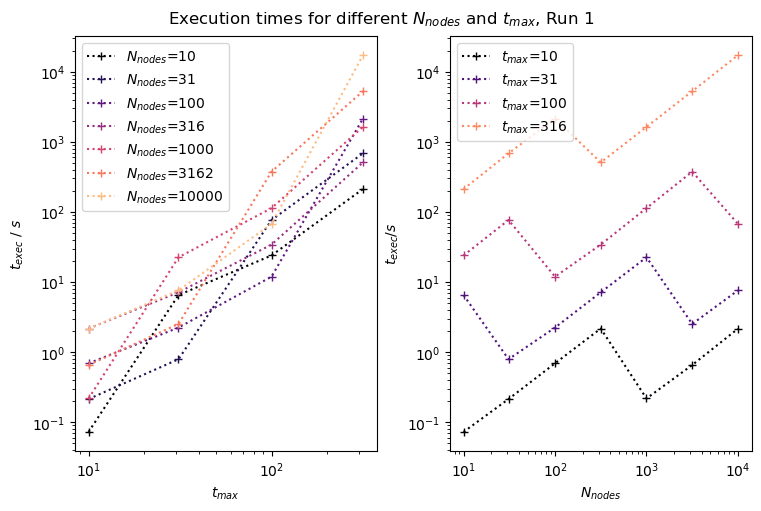

In [24]:
# Plot 1_1 -- (x,y) = (t_max,t_exec); loop over N_nodes
scale = 5
fig2 = plt.figure(figsize=(1.5 * scale, 1 * scale), constrained_layout=True)

x_T = np.array(t_arr)
y_T = [exec_times_NT[:, i] for i, _ in enumerate(n_arr)]

ax2_1 = fig2.add_subplot(1, 2, 1)
ax2_1.set_prop_cycle("color", cmap2(np.linspace(0, 1 - 1 / len(y_T), len(y_T))))
for y in y_T:
    ax2_1.plot(x_T, y, ls=":", marker="+")

ax2_1.legend(["$N_{nodes}$=" + str(N) for N in n_arr])
ax2_1.set_xlabel("$t_{max}$")
ax2_1.set_xscale("log")
ax2_1.set_ylabel("$t_{exec}\ /\ s$")
ax2_1.set_yscale("log")


# Plot 1_2 -- (x,y) = (N_nodes,t_exec); loop over t_max
x_N = np.array(n_arr)
y_N = [exec_times_NT[i, :] for i, _ in enumerate(t_arr)]

ax2_2 = fig2.add_subplot(1, 2, 2)
ax2_2.set_prop_cycle("color", cmap2(np.linspace(0, 1 - 1 / len(y_N), len(y_N))))
for y in y_N:
    ax2_2.plot(x_N, y, ls=":", marker="+")

ax2_2.legend(
    ["$t_{max}$=" + str(t) for t in t_arr]
)  # because t_arr used arbitrary rates
ax2_2.set_xlabel("$N_{nodes}$")
ax2_2.set_xscale("log")
ax2_2.set_ylabel("$t_{exec}/s$")
ax2_2.set_yscale("log")

fig2.suptitle("Execution times for different $N_{nodes}$ and $t_{max}$, Run 1")
plt.show()

## Figure 2

Distance (KLD, lin., quad.), given
1. $(r,h)\in\{ (1,1),(0.1,5),(5,0.1)\}$
2. $N_{nodes}\in 1e(1,1.5,2,2.5,3,3.5,4)$

In [8]:
# give to-be-analysed data
## I know this is rudimental, but hey, it works for me, for now.

data_dir = "../tests/data/2024-03--Run0/"

# 1.) (r,h) data
rates = [(0.1, 5), (5, 0.1), (1, 1)]
N_arr = [int(10**N) for N in np.arange(1, 4.5, 0.5)]

res2 = []
t_exec_arr = []
mu_arr = []
kld_arr = []
dist_arr = []


for N in n_arr:
    for i in rates:
        if i[0] == 1 and i[1] == 1:
            filename = "out--N_nodes-" + str(N) + "--t_max-100.pkl"
        else:
            filename = (
                "out--N_nodes-"
                + str(N)
                + "--r-"
                + str(i[0])
                + "--h-"
                + str(i[1])
                + ".pkl"
            )
        with open(data_dir + filename, "rb") as export:
            res2.append(filename)
            output = pickle.load(export)
            t_exec_arr.append(output["t_exec"])
            mu_arr.append(output["mu_nodes"])
            kld_arr.append(output["kl_divs"])
            dist_arr.append(output["p_distances"])


np.array(res2).reshape(len(N_arr), len(rates))

array([['out--N_nodes-10--r-0.1--h-5.pkl',
        'out--N_nodes-10--r-5--h-0.1.pkl',
        'out--N_nodes-10--t_max-100.pkl'],
       ['out--N_nodes-31--r-0.1--h-5.pkl',
        'out--N_nodes-31--r-5--h-0.1.pkl',
        'out--N_nodes-31--t_max-100.pkl'],
       ['out--N_nodes-100--r-0.1--h-5.pkl',
        'out--N_nodes-100--r-5--h-0.1.pkl',
        'out--N_nodes-100--t_max-100.pkl'],
       ['out--N_nodes-316--r-0.1--h-5.pkl',
        'out--N_nodes-316--r-5--h-0.1.pkl',
        'out--N_nodes-316--t_max-100.pkl'],
       ['out--N_nodes-1000--r-0.1--h-5.pkl',
        'out--N_nodes-1000--r-5--h-0.1.pkl',
        'out--N_nodes-1000--t_max-100.pkl'],
       ['out--N_nodes-3162--r-0.1--h-5.pkl',
        'out--N_nodes-3162--r-5--h-0.1.pkl',
        'out--N_nodes-3162--t_max-100.pkl'],
       ['out--N_nodes-10000--r-0.1--h-5.pkl',
        'out--N_nodes-10000--r-5--h-0.1.pkl',
        'out--N_nodes-10000--t_max-100.pkl']], dtype='<U34')

In [9]:
# Plan:
# 1 subplot per N_nodes, 3 lines per subplot (r,h)
# Plot KLDs, quad. errors

# Plot some example for mu_node_i over time
for i in [1, 3, 5]:
    for j in [0, 1]:
        print(res2[i * 3 + j])
res2

out--N_nodes-31--r-0.1--h-5.pkl
out--N_nodes-31--r-5--h-0.1.pkl
out--N_nodes-316--r-0.1--h-5.pkl
out--N_nodes-316--r-5--h-0.1.pkl
out--N_nodes-3162--r-0.1--h-5.pkl
out--N_nodes-3162--r-5--h-0.1.pkl


['out--N_nodes-10--r-0.1--h-5.pkl',
 'out--N_nodes-10--r-5--h-0.1.pkl',
 'out--N_nodes-10--t_max-100.pkl',
 'out--N_nodes-31--r-0.1--h-5.pkl',
 'out--N_nodes-31--r-5--h-0.1.pkl',
 'out--N_nodes-31--t_max-100.pkl',
 'out--N_nodes-100--r-0.1--h-5.pkl',
 'out--N_nodes-100--r-5--h-0.1.pkl',
 'out--N_nodes-100--t_max-100.pkl',
 'out--N_nodes-316--r-0.1--h-5.pkl',
 'out--N_nodes-316--r-5--h-0.1.pkl',
 'out--N_nodes-316--t_max-100.pkl',
 'out--N_nodes-1000--r-0.1--h-5.pkl',
 'out--N_nodes-1000--r-5--h-0.1.pkl',
 'out--N_nodes-1000--t_max-100.pkl',
 'out--N_nodes-3162--r-0.1--h-5.pkl',
 'out--N_nodes-3162--r-5--h-0.1.pkl',
 'out--N_nodes-3162--t_max-100.pkl',
 'out--N_nodes-10000--r-0.1--h-5.pkl',
 'out--N_nodes-10000--r-5--h-0.1.pkl',
 'out--N_nodes-10000--t_max-100.pkl']

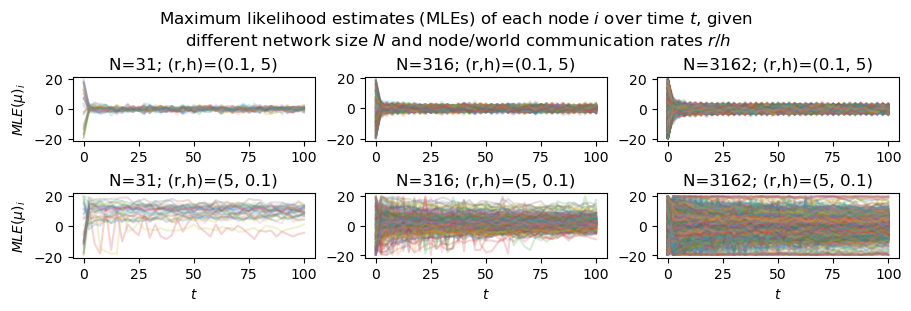

In [26]:
# MLE-t plots

N_ex = [1, 3, 5]
# N_equiv = [31, 316, 3162]
rates_ex = [0, 1]  # ==[(0.1, 5), (5, 0.1)]
rates_equiv = [(0.1, 5), (5, 0.1)]

fig, ax = plt.subplots(
    len(rates_ex),
    len(N_ex),
    figsize=(1.5 * 3 * len(rates_ex), 1 * len(N_ex)),
    constrained_layout=True,
)
# fig.tight_layout()

for i, _ in enumerate(N_ex):
    for j in rates_ex:
        mu_tmp = np.array(mu_arr[N_ex[i] * len(rates) + j]).T
        for y in mu_tmp:
            x = np.arange(0, len(y) * 2.5, 2.5)
            ax[j, i].plot(x, y, alpha=0.2)
        ax[j, i].set_title("N=" + str(len(mu_tmp)) + "; (r,h)=" + str(rates_equiv[j]))
ax[0, 0].set_ylabel("$MLE(\mu)_i$")
ax[1, 0].set_ylabel("$MLE(\mu)_i$")
ax[1, 0].set_xlabel("$t$")
ax[1, 1].set_xlabel("$t$")
ax[1, 2].set_xlabel("$t$")
fig.suptitle(
    "Maximum likelihood estimates (MLEs) of each node $i$ over time $t$, given\n different network size $N$ and node/world communication rates $r$/$h$"
)

plt.show()
fig.savefig("MLEs.png")

In [11]:
sigma = 5

SyntaxError: incomplete input (362466422.py, line 7)